# Experiment Results
## Experiment picker

Use the widget below to select and load experiments from `data/`.

**Mode Selection:**
- **Single Experiment** (default): Select one experiment and automatically load all its configurations. Uses a radio button for experiment selection.
- **Multiple Experiments**: Select multiple experiments and customize which configurations to load for each. Uses checkboxes for selection.

**Configuration Handling:**
- If an experiment contains configuration subfolders (for example `data/exp/<cfg>/001`), it will be treated as a multi-config experiment and config pickers will be shown.
- If the experiment has `001` directly under `data/exp/001`, it will be treated as a single-run experiment and no config picker will be shown.

After selecting experiments and configurations, click **Choose experiment(s)** to load the data. The results will be printed and saved to `picker.last_loaded`, and a CSV picker will automatically appear to select which data files to load.

> Tip: If the widgets do not show or importing `plothelpers2` raises an error, install the widget dependency with:
> ```bash
> pip install ipywidgets
> ```


In [3]:
# EXP picker
from pathlib import Path
import plothelpers2 as ph

# create and show the picker (data folder is relative to this notebook)
DATA_DIR = Path('data')
picker = ph.create_and_show_picker(DATA_DIR)

# Wrap the original load button callback to also show CSV picker after loading
original_callback = picker.load_button._click_handlers.callbacks[0] if picker.load_button._click_handlers.callbacks else None

def enhanced_load_callback(btn):
    # Call original callback
    if original_callback:
        original_callback(btn)
    
    # After experiments are loaded, automatically show CSV picker
    if picker.last_loaded:
        get_selections = ph.create_csv_picker_for_loaded_paths(picker, DATA_DIR)
        globals()['get_selections'] = get_selections

# Replace the callback
picker.load_button._click_handlers.callbacks = []
picker.load_button.on_click(enhanced_load_callback)

Button(description='Load data', style=ButtonStyle())

Output()

## Data Preview

In [4]:
# Preview helper: choose experiment & see a combined preview (no csv_basename key anymore)
ph.show_loaded_preview()


## Block Production Summary
Shows the number of blocks produced by each robot (from monitor.log files).

In [5]:
# Show block production counts from monitor.log files
ph.show_block_production_summary()

# You can also access the data using helper functions:
# ph.get_block_production_count(experiment, rep, robot)
# Examples:
#   ph.get_block_production_count('ProofOfWork_5', '1', 2)  # Get count for robot 2 in rep 1
#   ph.get_block_production_count('ProofOfWork_5', '1')     # Get all robots in rep 1
#   ph.get_block_production_count('ProofOfWork_5')          # Get all reps

# Or access the raw dict directly:
# block_production_counts[experiment][rep][robot] -> count

Block Production Summary (3000 robots)


,Experiment,Rep,Robot,Blocks Produced
0,experiment_different_consensus_2/ProofOfAuthor...,001,1,9
1,experiment_different_consensus_2/ProofOfAuthor...,001,2,8
2,experiment_different_consensus_2/ProofOfAuthor...,001,3,9
3,experiment_different_consensus_2/ProofOfAuthor...,001,4,9
4,experiment_different_consensus_2/ProofOfAuthor...,001,5,8
...,...,...,...,...
2995,experiment_different_consensus_2/ProofOfWork_5,010,1,3
2996,experiment_different_consensus_2/ProofOfWork_5,010,2,2
2997,experiment_different_consensus_2/ProofOfWork_5,010,3,6
2998,experiment_different_consensus_2/ProofOfWork_5,010,4,12



Statistics by Experiment:


,Robots,Total,Mean,Median,Std,Min,Max
Experiment,,,,,,,
experiment_different_consensus_2/ProofOfAuthority_10,100,793,7.930000,8.0,1.437274,5,11
experiment_different_consensus_2/ProofOfAuthority_15,150,881,5.873333,6.0,1.291670,3,9
experiment_different_consensus_2/ProofOfAuthority_20,200,991,4.955000,5.0,1.379307,2,9
experiment_different_consensus_2/ProofOfAuthority_25,250,1054,4.216000,4.0,1.377291,1,8
experiment_different_consensus_2/ProofOfAuthority_5,50,891,17.820000,18.0,2.370654,12,22
experiment_different_consensus_2/ProofOfConnection_10,100,2293,22.930000,18.5,21.443492,0,118
experiment_different_consensus_2/ProofOfConnection_15,150,1654,11.026667,6.0,14.850461,0,95
experiment_different_consensus_2/ProofOfConnection_20,200,1613,8.065000,2.0,11.944208,0,71
experiment_different_consensus_2/ProofOfConnection_25,250,1322,5.288000,1.0,9.314941,0,56



Overall Total: 38,427 blocks produced
Average per robot: 12.8 blocks


### Interactive Block Production Picker
Filter by experiment, rep, and robot using the same picker UI.
import plothelpers2 as ph
ph.show_block_production_picker()

In [6]:
import plothelpers2 as ph
ph.show_block_production_picker()

### Custom Histogram Examples
You can now customize bins, labels, and title:
```python
# Custom bins
ph.show_histogram('TELAPSED', bins=200)

# Custom labels and title
ph.show_histogram('TELAPSED', bins=50, xlabel='Time [seconds]', title='Custom Title')

# Only change some parameters (others use defaults)
ph.show_histogram('TELAPSED', xlabel='Block Delay', title='My Analysis')
```


## Time elapsed between blocks (histogram)

In [7]:
# TELAPSED histogram
ph.show_histogram('TELAPSED',xlabel='time',title='Time elapsed between blocks')


## Time elapsed between block production to reception

In [8]:
# TPROD histogram - time between block productions
ph.show_histogram('TIMESTAMP', 'HASH',xlabel='time',title='Time between block productions')


## Block propegation time (BPT)

/home/dodo/toychain-argos/BachelorProjekt/results/plothelpers2.py:1256: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


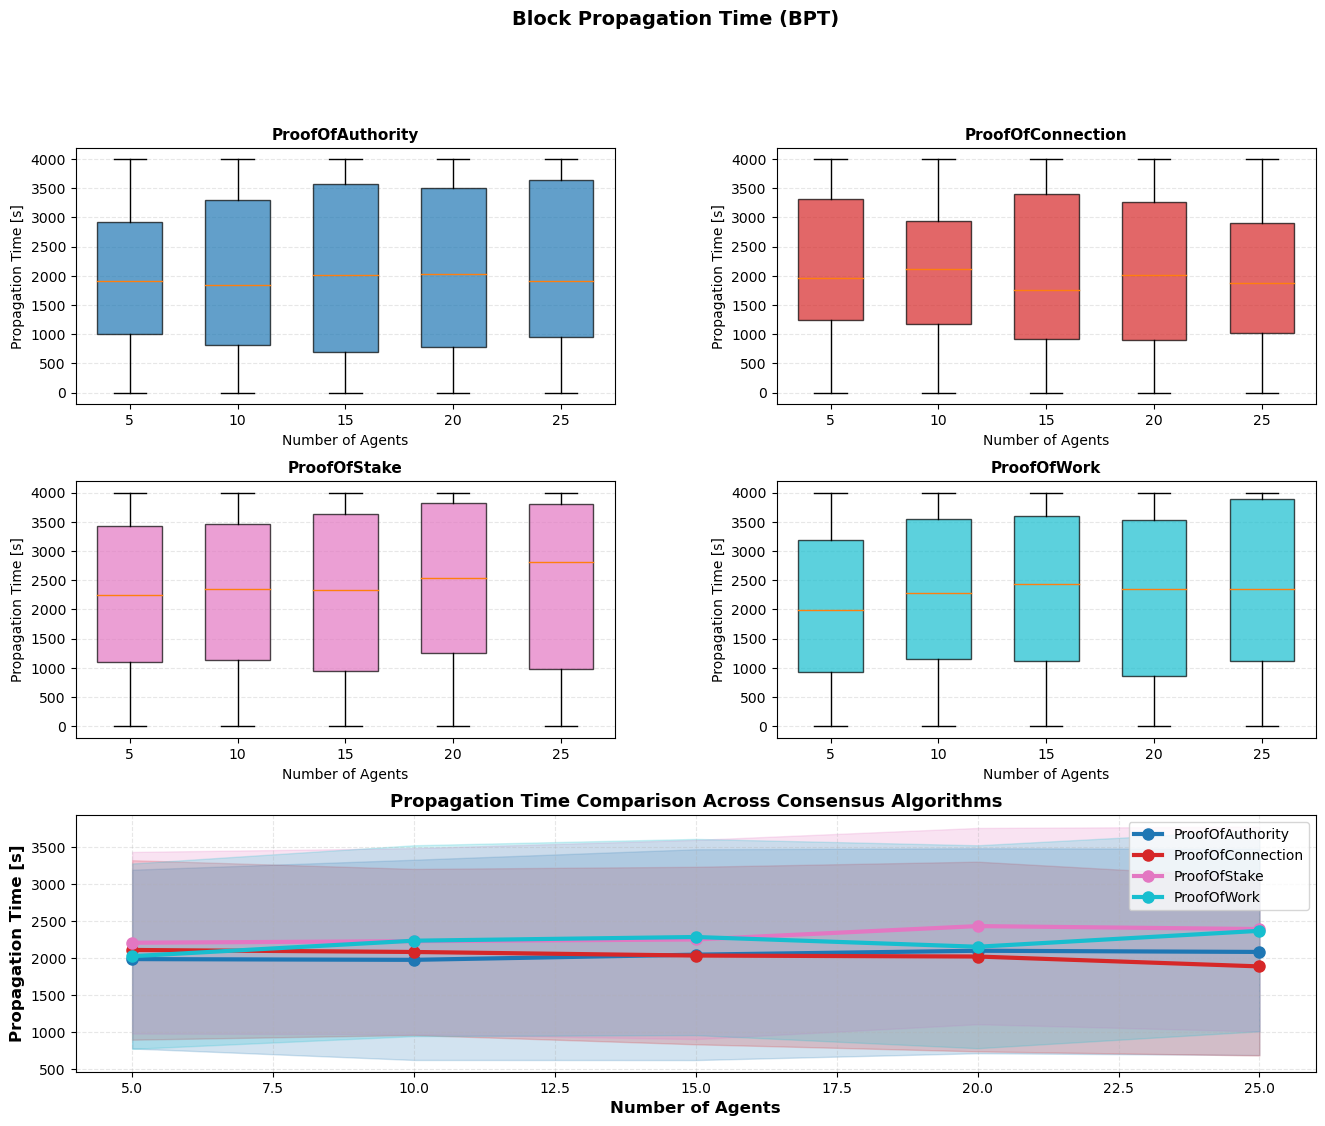


Summary Statistics (Propagation Time [s]):
                              count         mean  median          std  min   max
consensus         num_agents                                                    
ProofOfAuthority  5             657  1988.465753  1912.0  1209.955189    0  3991
                  10            436  1978.353211  1838.5  1355.227831    0  3991
                  15            385  2048.683117  2017.0  1426.809970    0  3991
                  20            397  2101.455919  2038.0  1387.035836    0  3991
                  25            376  2085.507979  1912.0  1396.052599    0  3991
ProofOfConnection 5            2659  2112.289959  1954.0  1214.982749    0  3991
                  10           2295  2084.991721  2122.0  1124.243832    0  3991
                  15           1663  2036.453397  1765.0  1201.386568    0  3991
                  20           1581  2023.356104  2017.0  1283.921331    0  3991
                  25           1331  1889.572502  1870.0  1205.51

In [9]:
# Block propagation time boxplot
ph.show_block_propagation_boxplot()


## Block production efficency (BPE)
Shows chain efficiency as a percentage: max(HEIGHT) / total_produced_blocks × 100. This represents what percentage of produced blocks ended up in the longest chain.agents.

/home/dodo/toychain-argos/BachelorProjekt/results/plothelpers2.py:1256: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


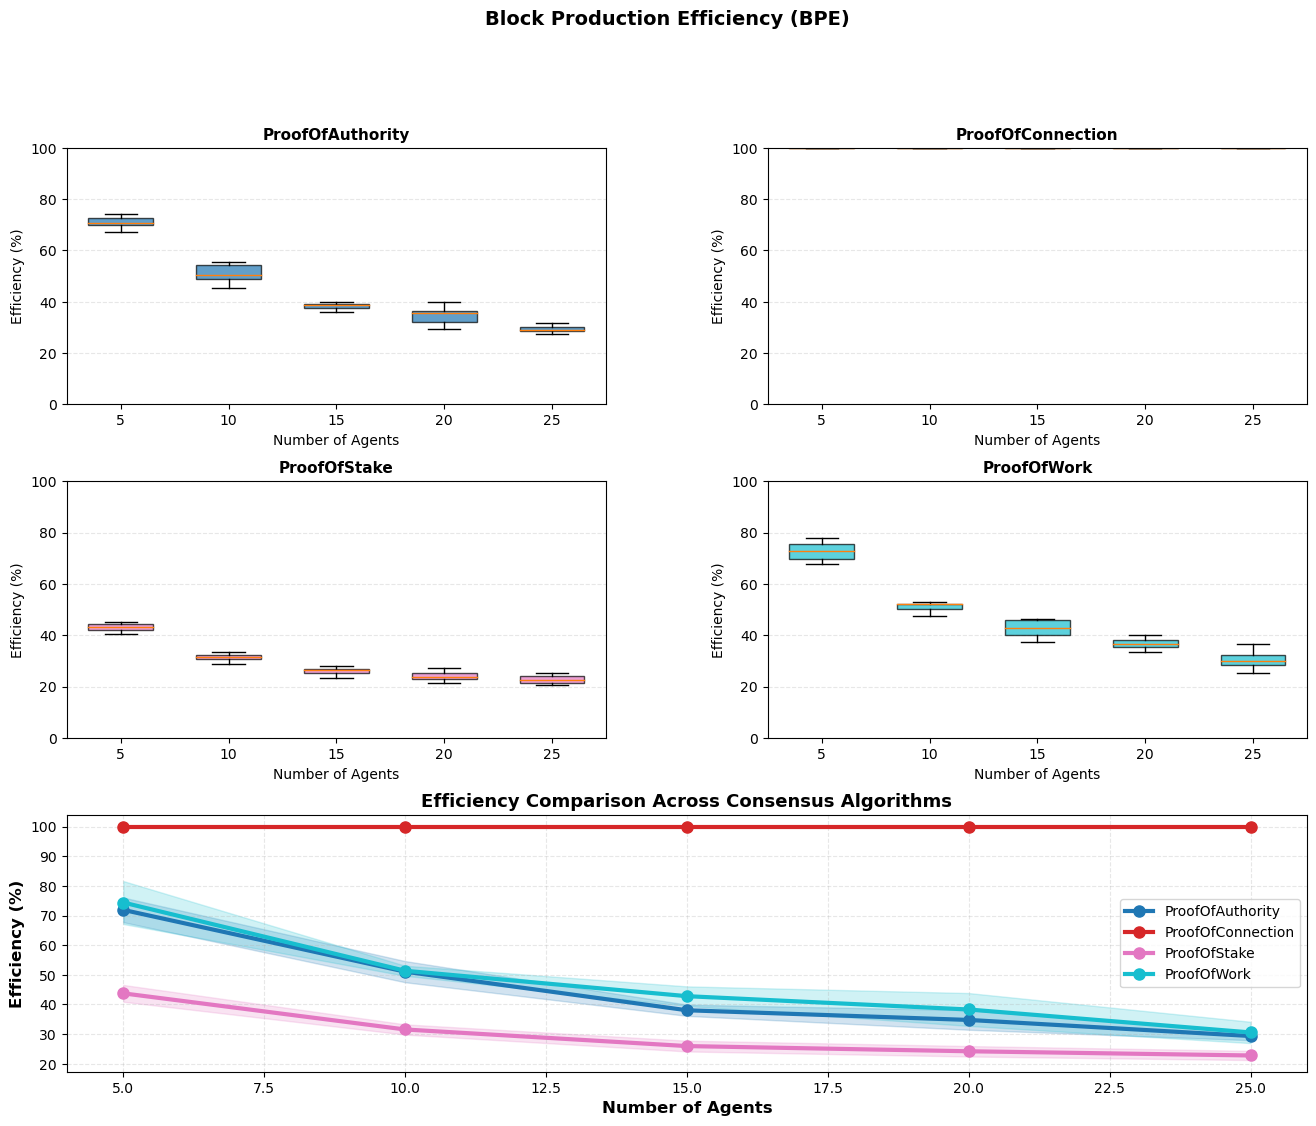


Summary Statistics (Efficiency (%)):
                              count        mean      median       std         min         max
consensus         num_agents                                                                 
ProofOfAuthority  5              10   71.931486   70.794118  4.152057   67.346939   82.352941
                  10             10   51.079137   50.595238  3.569752   45.360825   55.555556
                  15             10   38.050458   38.651515  1.890183   33.695652   39.784946
                  20             10   34.782461   35.533911  3.307022   29.292929   39.759036
                  25             10   29.359783   29.006410  1.412801   27.272727   31.623932
ProofOfConnection 5              10  100.000000  100.000000  0.000000  100.000000  100.000000
                  10             10  100.000000  100.000000  0.000000  100.000000  100.000000
                  15             10  100.000000  100.000000  0.000000  100.000000  100.000000
                  20  

In [10]:
# Efficiency boxplot (% main-chain blocks)
ph.show_efficiency_boxplot()
